# Twitter sentiment analysis

## Imports and load data

In [20]:
from searchtweets import ResultStream, gen_rule_payload, load_credentials, collect_results

# general imports
import numpy as np
import pandas as pd
import subprocess
from textblob import TextBlob
import re
import time
import datetime

# plotting and visualization
import matplotlib
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def runCmd(cmd, run=False):
    '''
    use stdout to run command and shell=True to allow command to be entered as a string
    use rstrip() to remove carriage return and decode binary form to string. 
     '''
    if run == False:
        try:
            output_cmd = subprocess.check_output(cmd, stderr=subprocess.STDOUT, shell=True)
            output_cmd = output_cmd.rstrip().decode('UTF-8')
        except subprocess.CalledProccessError as e:
            print("Command", e.cmd, "returned with error code", e.returncode)
            print("setting output_cmd to empty array")
            output_cmd = []
        return output_cmd
    else:
        subprocess.Popen(cmd, stderr=subprocess.STDOUT, shell=True)
        return None

def S2_from_csv(filename_A, filename_B):
    # assumption, Tweets file ends with 'Tweets.csv'
    filename_tweets, filename_meta = '', ''
    if 'Tweets.csv' in filename_A:
        filename_tweets, filename_meta = filename_A, filename_B
    else:
        filename_tweets, filename_meta = filename_B, filename_A
    S2_tweets = pd.read_csv(filename_tweets, encoding='latin')
    S2_meta = pd.read_csv(filename_meta, parse_dates=['date'], encoding='latin')
    S2 = pd.concat([S2_tweets, S2_meta], axis=1)
    return S2

### file name

In [11]:
current_dir = ['complete_tweets/' + x for x in runCmd('ls complete_tweets/').split('\n') if '.csv' in x]
print("Data files available to load")
for i, x in enumerate(current_dir):
    print(str(i), " ", x)
    
value_selection = input("\nPlease input file numbers separated by a space ")
value_selection = [ int(x) for x in value_selection.split() ]
S2 = S2_from_csv(current_dir[value_selection[0]], current_dir[value_selection[1]])

Data files available to load
0   complete_tweets/tweets_2018-0916_2018-0930_Metadata.csv
1   complete_tweets/tweets_2018-0916_2018-0930_Tweets.csv
2   complete_tweets/tweets_2018-10-11_2018-10-15_Metadata.csv
3   complete_tweets/tweets_2018-10-11_2018-10-15_Tweets.csv
4   complete_tweets/tweets_2018-10-16_2018-10-31_Metadata.csv
5   complete_tweets/tweets_2018-10-16_2018-10-31_Tweets.csv

Please input file numbers separated by a space 4 5


In [12]:
S2.iloc[100:110,:]

,tweets,date,user_name,user_screen_name,user_followers,user_friends,user_verified,user_language,retweet_count,favorite_count
100,Bitcoin Cash Price Analysis: Bitmain IPO specu...,2018-10-15 23:57:05,Crypto Markets Daily,cryptomarketsd,231,275,False,en,0,0
101,RT @YuTuCoin: Another of our live interview co...,2018-10-15 23:57:05,Aly Annuri,AlyAnnuri,3099,3119,False,id,0,0
102,RT @Noricoin_banker: Bitcoin SVã®ãã­ãã¯...,2018-10-15 23:57:03,ã¡ã å¤ª@ã½ãéª¨*BCHisCASH*,chiuta2010,1053,565,False,ja,0,0
103,RT @YuTuCoin: Here's our second https://t.co/d...,2018-10-15 23:56:58,Aly Annuri,AlyAnnuri,3099,3119,False,id,0,0
104,"RT @APompliano: According to @saifedean, every...",2018-10-15 23:56:57,BigNewt23â¨ðððºð¸,BigNewt23,251,198,False,en,0,0
105,#wisdom\n\nPost-Bitcoin-Maximalism by @ferdous...,2018-10-15 23:56:56,Rory Houston,roryhouston83,195,474,False,en,0,1
106,RT @Mirk09733840: ABCC 5th Bounty is back!\nRa...,2018-10-15 23:56:55,Entertainment Weekly,akekekekebish,119,4992,False,en,0,0
107,RT @Mirk09733840: ABCC 5th Bounty is back!\nRa...,2018-10-15 23:56:54,.,KlSSNMAKEUP,310,3937,False,en,0,0
108,RT @Mirk09733840: ABCC 5th Bounty is back!\nRa...,2018-10-15 23:56:54,Good Morning America,GMAStans,101,4316,False,en,0,0
109,"RT @TuurDemeester: Impressed to see @Fidelity,...",2018-10-15 23:56:53,Yaz,YazCrypto,6065,117,False,en,0,0


## Sentiment analysis

In [13]:
def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    
    textblob already has a trained analyser to work 
    with different machine learning models on 
    natural language processing.
    
    Might want to train our own model
    '''
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1
    

def sentiment_analysis(S2):
    # We create a column with the result of the analysis:
    S2['SA'] = np.array([ analize_sentiment(tweet) for tweet in S2['tweets'] ])
    
    # We construct lists with classified tweets:
    pos_tweets = [ tweet for index, tweet in enumerate(S2['tweets']) if S2['SA'][index] > 0]
    neu_tweets = [ tweet for index, tweet in enumerate(S2['tweets']) if S2['SA'][index] == 0]
    neg_tweets = [ tweet for index, tweet in enumerate(S2['tweets']) if S2['SA'][index] < 0]

    # We print percentages:
    print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(S2['tweets'])))
    print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(S2['tweets'])))
    print("Percentage de negative tweets: {}%".format(len(neg_tweets)*100/len(S2['tweets'])))

In [15]:
sentiment_analysis(S2)

Percentage of positive tweets: 36.85%
Percentage of neutral tweets: 52.4125%
Percentage de negative tweets: 10.7375%


## Stacked bar chart

In [16]:
#S2['rounded_day'] = S2['date'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day))
S2['rounded_hour'] = S2['date'].dt.round('H')

S3_A = S2.groupby(['rounded_hour']).agg('count').reset_index()
S3 = S2.groupby(['rounded_hour', 'SA']).agg('count').reset_index()
S3 = S3.assign(count = S3['tweets']).loc[:,['rounded_hour', 'SA', 'count']]
S3_pivot = S3.pivot(index = 'rounded_hour', columns='SA', values='count')

S3_pivot.head()

SA,-1,0,1
rounded_hour,,,
2018-10-16 00:00:00,35,239,226
2018-10-16 12:00:00,36,276,188
2018-10-17 00:00:00,71,237,192
2018-10-17 12:00:00,71,268,161
2018-10-18 00:00:00,44,241,215


In [21]:
'''cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ('Qualitative', [
            'Pastel1', 'Pastel2', 'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3',
            'tab10', 'tab20', 'tab20b', 'tab20c']),
         ('Miscellaneous', [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])]
'''

def plot_stacked_bar(df, x, y, nrows=1, ncols=1):
    
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, dpi=1200)
    #fig, ax = plt.subplots()
    
    #ax.plot(df[x], df[y], '.')
    df.plot.bar(stacked=True, ax=ax, colormap='Spectral')
    
    # Make most of the ticklabels empty so the labels don't get too crowded
    ticklabels = ['']*len(df.index)
    # Every 5th ticklable shows the month and day
    ticklabels[::8] = [item.strftime('%m.%d') for item in df.index[::8]]
    # Every 12th ticklabel includes the year
    #ticklabels[::12] = [item.strftime('%b %d\n%Y') for item in df.index[::12]]
    plt.style.use('ggplot')
    ax.legend(loc=0)
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    plt.gcf().autofmt_xdate()
    
    #fig.savefig('stacked_bar_chart_SA.png')
    #plt.close()
    plt.show()

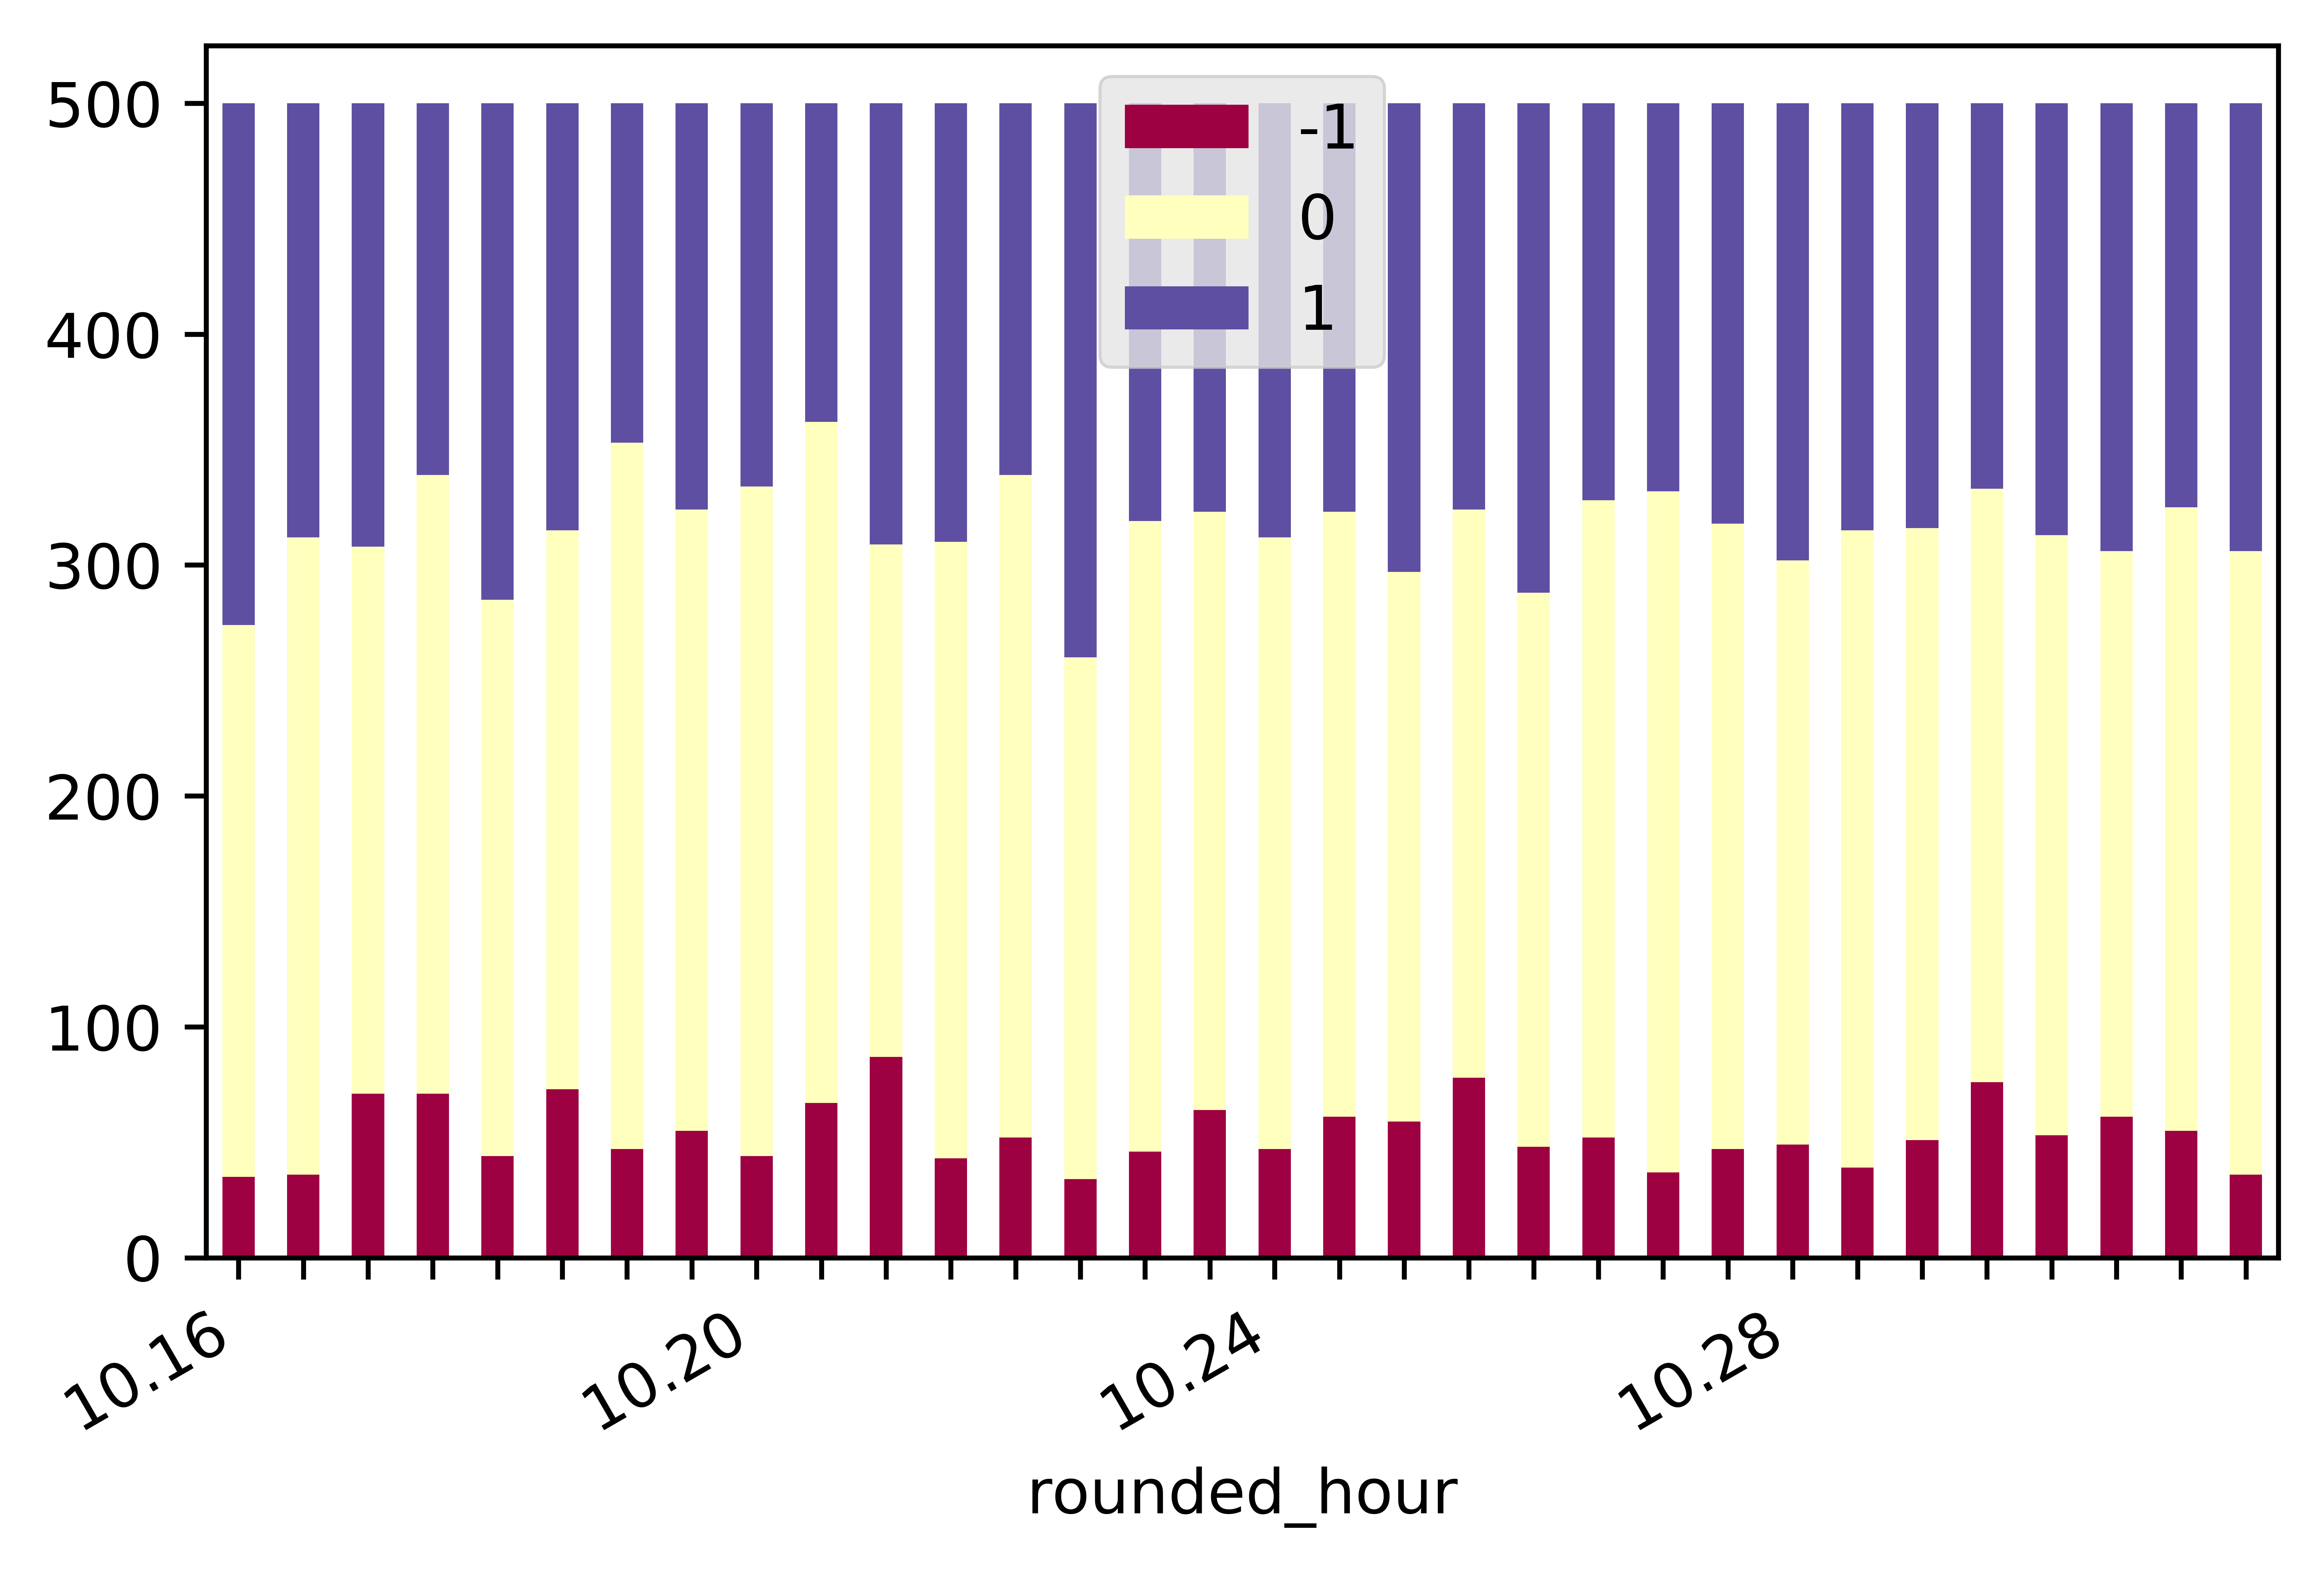

In [22]:
plot_stacked_bar(S3_pivot, 'rounded_hour', 'SA')